In [1]:
import os
import torch
from torchvision.datasets.utils import download_url
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import datetime

In [2]:
import models

In [3]:
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = False

### Load data

In [4]:
# Read data - short version 3400+ documents
reuters = pd.read_pickle('input/reuters_small.pkl')

In [5]:
# OR 8xsmall size
reuters = pd.read_pickle('input/reuters_small8.pkl')

In [4]:
# OR load full data, if produced. 435 MB. NOT in Github currently. 
# You can produce this in about 30 min with preprocess_data.ipynb
reuters = pd.read_pickle('input/reuters_all.pkl')

In [5]:
print(len(reuters))
reuters[0:2]

299773


,codes,headline,text
0,"[C18, C181, CCAT]",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia..."
1,"[G15, GCAT]",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...


In [6]:
# read classcodes
classcodes= pd.read_csv('input/classcodes.csv')
print(len(classcodes))
#classcodes[0:12]

# add index field to DataFrame
classcodes = classcodes.reset_index()
# Create dictionary index/int to classcode and classcode to int
itocode = dict(zip(classcodes.index, classcodes.Code))
codetoi = dict(zip(classcodes.Code, classcodes.index))
def listToInt(mylist):
    return [codetoi[item] for item in mylist]

reuters['codes'] = [listToInt(codelist) for codelist in reuters.codes]
reuters[0:3]
# Multihot, for single list - one row
def multihot(tags):
    return [1 if tag in tags else 0 for tag in taglist]

# list of classes, 126 int: [0...125]
taglist = list(classcodes.index)
Y_hot = [multihot(claslist) for claslist in reuters.codes]
reuters['codes'] = Y_hot

126


In [7]:
print(len(reuters))
reuters[0:2]

299773


,codes,headline,text
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...


### Using DataSet


Example in:
https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/A%20-%20Using%20TorchText%20with%20Your%20Own%20Datasets.ipynb

In [8]:
#Define the Fields
TEXT = data.Field()
HEADLINE = data.Field()
LABELS = data.LabelField(sequential=False, use_vocab=False)

In [9]:
# Put data in random order
idx = np.random.permutation(len(reuters))
reuters = reuters.iloc[idx]

In [10]:
# split it
size = len(reuters)
train_size = int(0.7*size)
test_size = int(0.85*size)
# val is rest

train = reuters[0: train_size]
val = reuters[train_size : test_size]
test = reuters[test_size : size]

train.to_json('input/train.json', orient='records', lines=True)
test.to_json('input/test.json', orient='records', lines=True)
val.to_json('input/val.json', orient='records', lines=True)

In [11]:
# Tell torchText which Fields to apply to which json elements
fields = {'headline': ('h', HEADLINE), 'text': ('t', TEXT), 'codes': ('l', LABELS)}
fields

{'headline': ('h', <torchtext.data.field.Field at 0x7f6ebcfb8908>),
 'text': ('t', <torchtext.data.field.Field at 0x7f6ebcfb8898>),
 'codes': ('l', <torchtext.data.field.LabelField at 0x7f6ebcfb88d0>)}

In [12]:
# Create dataset (TabularDataset)
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'input',
                                        train = 'train.json',
                                        validation = 'val.json',
                                        test = 'test.json',
                                        format = 'json',
                                        fields = fields
)
# test
#print(vars(train_data[2]))

In [13]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t)
)

In [14]:
# GLOVE
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.50d")
HEADLINE.build_vocab(train)
LABELS.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 50])


### Print some info

In [16]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print('------------')
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABELS vocabulary: {len(LABELS.vocab)}")

Number of training examples: 209841
Number of validation examples: 44966
Number of testing examples: 44966
------------
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABELS vocabulary: 3


In [17]:
print(TEXT.vocab.freqs.most_common(10))
print('-----')
print(TEXT.vocab.itos[:10])
print(LABELS.vocab.stoi)

[('the', 2179285), ('of', 1166347), ('to', 1162717), ('in', 925061), ('and', 867952), ('a', 866551), ('on', 533808), ('said', 413564), ('for', 406483), ('The', 343804)]
-----
['<unk>', '<pad>', 'the', 'of', 'to', 'in', 'and', 'a', 'on', 'said']
defaultdict(<function _default_unk_index at 0x7efee0ed2d08>, {'codes': 0, 'headline': 1, 'text': 2})


### F1 accuracy

The results will be ranked according to the highest micro-averaged F1 score. 
This will be calculated using the f1_score function found in scikit-learn, using a command like 
f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred 
the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document
i contains the label j.

Scikit:  Micro-average in F1-score
 
'micro':
    Calculate metrics globally by counting the total true positives, false negatives and false positives.

In [15]:
# f1 score for BATCH
from sklearn.metrics import f1_score
def f1_accuracy(preds, y):
    """
    Returns f1 accuracy from sklearn
    """
    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    preds_cpu = rounded_preds.cpu().data.numpy()
    y_cpu = y.cpu().data.numpy()
    f1 = f1_score(y_cpu, preds_cpu, average='micro')
    return f1 

In [16]:
def f1_own_accuracy(preds, y):
    '''Returns counts of true_pos, false_pos and false_negative.
    For counting precision, recall and F1 globally
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    '''
    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    preds = rounded_preds.cpu().data.numpy()
    y = y.cpu().data.numpy()
        
    # True positive
    tpos = np.sum(np.logical_and(preds == 1, y == 1))
 
    # True negative
    #tneg = np.sum(np.logical_and(preds == 0, y == 0))
 
    # False positive
    fpos = np.sum(np.logical_and(preds == 1, y == 0))
 
    # False negative
    fneg = np.sum(np.logical_and(preds == 0, y == 1))

    return tpos, fpos, fneg

In [17]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [18]:
# F1 version
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0
    
    model.train()
    
    for batch in iterator:
        if batch.t.shape[1] != BATCH_SIZE:
              continue
        
        optimizer.zero_grad()
                
        predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
        
        loss = criterion(predictions, batch.l.float())
        
        tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
        epoch_tpos += tpos
        epoch_fpos += fpos
        epoch_fneg += fneg
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc.item()
    
    # Counted f1-score is Micro-average version
    # avoid div by zero with epsilon. 
    # F1 for 0 - no labels is not defined, but here we give it score 1
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps )
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +2*eps))
    
    # if f1 is 1 with 0 labels (undefined), make it 0 to make plotting early train more realistic
    if epoch_tpos==0:
        epoch_f1 = 0
    
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

In [19]:
# F1 version
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    #epoch_acc = 0
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0    
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            if batch.t.shape[1] != BATCH_SIZE:
                continue

            predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
            
            loss = criterion(predictions, batch.l.float())
            
            tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
            epoch_tpos += tpos
            epoch_fpos += fpos
            epoch_fneg += fneg            

            epoch_loss += loss.item()
            #epoch_acc += acc.item()

    # avoid div by zero with epsilon
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps)
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +2*eps))          
    
    # zero true_positive can cause F1=1, (because only 2*(epsilon / 2epsilon) remains, leading to 1)
    # fix it to zero
    if (epoch_precision==0 and epoch_recall==0):
        epoch_f1 = 0
    
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

In [20]:
def predict(model, iterator):
        
    model.eval()
    preds = []
    
    with torch.no_grad():
    
        for batch in iterator:
            #if batch.t.shape[1] != BATCH_SIZE:
            #    continue

            predictions = model(torch.cat((batch.t, batch.h))).squeeze(1)
            #predictions = model(batch)
            
            # unpack the #batch nr of predictions and add individually
            for item in predictions:
                preds.append(item)
    
    return preds

### Load model

In [21]:
# Common
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 126

### Models to try

Add wanted models to list, then train them all

In [39]:
# place to put model definitions
try_models = []
try_descs = []
try_epochs = []

### Try for best accuracy

In [40]:
# CNN with high nr of filters
N_FILTERS = 300
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5
N_EPOCHS = 6 # full data, try 6

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

# 14 epochs gave f1 0.84
desc = "CNN 300x3,5,7 filters"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [24]:
# LSTM 2
HIDDEN_DIM = 250
N_EPOCHS = 350 # small data
N_EPOCHS = 15 # try, full data
N_LAYERS = 1
BIDIRECTIONAL = False

model = models.LSTM(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)

#model.embedding.weight.data.copy_(TEXT.vocab.vectors)
optimizer = optim.SGD(model.parameters(), lr=0.02)

desc = "LSTM 250hidden 1-layer"

try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [25]:
# CNN-LSTM
HIDDEN_DIM = 200
FILTER_SIZES = [3,5,7]
N_FILTERS = 150
#N_EPOCHS= 300 # small data
N_EPOCHS= 15 # try, full data

model = models.CNN_LSTM(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, HIDDEN_DIM, device)
model.hidden = model.init_hidden(64)

desc = "CNN 100x3,5,7 filter + LSTM 100hidden"
try_models.append(model)
try_descs.append(desc)
try_epochs.append(N_EPOCHS)

In [26]:
# COMMON
def init_models():
    ''' init global parameters'''
    global model
    global optimizer
    global criterion
    global train_losses
    global train_f1s
    global val_losses
    global val_f1s
    global times
    global SEED
    global torch
    
    model = model.to(device)
    model.embedding.weight.data.copy_(pretrained_embeddings)

    optimizer = optim.Adam(model.parameters())

    #criterion = nn.BCEWithLogitsLoss()
    criterion = nn.BCELoss()
    criterion = criterion.to(device)

    # Reset 
    train_losses=[]
    train_f1s=[]
    val_losses=[]
    val_f1s=[]
    times=[]

    # If want repeatability
    SEED = 1
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    
    # Faster
    torch.backends.cudnn.deterministic = False

In [66]:
#model

In [67]:
#optimizer # default Adam

In [68]:
#optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [28]:
try_descs

['CNN 300x3,5,7 channel']

### Train all models

In [41]:
# Store results of training
results = pd.DataFrame()

for i in range(len(try_models)):
    
    model = try_models[i]
    desc = try_descs[i]
    epochs = try_epochs[i]
    print(f'Training model: {desc}')

    # init global parameters
    init_models()
    model_name = type(model).__name__
    
    test_f1 = 0 # skip for now

    #N_EPOCHS = 3
    N_EPOCHS = epochs

    for epoch in range(N_EPOCHS):

        start = time.time()
        train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
        end = time.time(); elapsed = end-start
    
        valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
        times.append(elapsed) 
        train_losses.append(train_loss); train_f1s.append(train_f1)
        val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
        print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        


    #Test F1-score
    test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_iterator, criterion)
    print(f'| Test Loss: {test_loss:.3f} ||Prec:{test_precision:.3f} |Rec:{test_recall:.3f} |Test F1:{test_f1: .3f} |')        
        
    # Store results
    times_cumul = pd.Series(times).cumsum() # cumulative time    
    results = results.append({'Model': model_name,
                          'Desc' : desc,
                          'Test_f1': test_f1,
                          'Time': times_cumul,
                          'Train_loss': pd.DataFrame({'Train_loss':train_losses}), 
                          'Train_f1': pd.DataFrame({'Train_f1':train_f1s}), 
                          'Val_loss': pd.DataFrame({'Val_loss':val_losses}), 
                          'Val_f1': pd.DataFrame({'Val_f1':val_f1s}),
                                         }, ignore_index=True)

    print(" ")
    print(f" Total time used for training: {sum(times)} s ##########")
    print(" ")

Training model: CNN 300x3,5,7 filters
| Ep:01 |Tr Loss:0.038 |Prec:0.849 |Rec:0.631 |f1:0.724 |Val Loss:0.032 |prec:0.796 |rec:0.815 |f1:0.806 |
| Ep:02 |Tr Loss:0.026 |Prec:0.878 |Rec:0.749 |f1:0.808 |Val Loss:0.031 |prec:0.786 |rec:0.853 |f1:0.818 |
| Ep:03 |Tr Loss:0.024 |Prec:0.886 |Rec:0.775 |f1:0.827 |Val Loss:0.029 |prec:0.795 |rec:0.860 |f1:0.826 |
| Ep:04 |Tr Loss:0.023 |Prec:0.892 |Rec:0.789 |f1:0.837 |Val Loss:0.029 |prec:0.802 |rec:0.857 |f1:0.829 |
| Ep:05 |Tr Loss:0.022 |Prec:0.895 |Rec:0.800 |f1:0.845 |Val Loss:0.027 |prec:0.814 |rec:0.859 |f1:0.836 |
| Ep:06 |Tr Loss:0.021 |Prec:0.900 |Rec:0.810 |f1:0.852 |Val Loss:0.027 |prec:0.820 |rec:0.855 |f1:0.837 |
| Test Loss: 0.026 ||Prec:0.823 |Rec:0.857 |Test F1: 0.840 |
 
 Total time used for training: 1865.744292974472 s ##########
 


In [42]:
results   

,Desc,Model,Test_f1,Time,Train_f1,Train_loss,Val_f1,Val_loss
0,LSTM 250hidden 1-layer,LSTM,0.842427,0 434.630763 1 866.679793 2 1302...,Train_f1 0 0.074411 1 0.122677 2 0.3...,Train_loss 0 0.087227 1 0.083753 2...,Val_f1 0 0.007499 1 0.011428 2 0.5...,Val_loss 0 0.086636 1 0.084859 2 0.0...
1,"CNN 100x3,5,7 channel + LSTM 100hidden",CNN_LSTM,0.840382,0 217.183331 1 433.603585 2 649...,Train_f1 0 0.481913 1 0.754988 2 0.8...,Train_loss 0 0.060964 1 0.032691 2...,Val_f1 0 0.682090 1 0.787052 2 0.8...,Val_loss 0 0.039626 1 0.029228 2 0.0...
2,"CNN 300x3,5,7 filters",CNN2,0.839627,0 307.850270 1 623.468602 2 939.34...,Train_f1 0 0.723693 1 0.808468 2 0.82669...,Train_loss 0 0.037796 1 0.026459 2 ...,Val_f1 0 0.805553 1 0.818077 2 0.82633...,Val_loss 0 0.031708 1 0.030958 2 0.02939...


### Save training results - score and time

In [43]:
datetime_string = datetime.now().strftime("%Y%m%d-%H%M")
print(datetime_string)
results.to_pickle('model_results/results_full'+datetime_string+'.pkl')

20190105-1230


### Save the model

For this version create the model object with same paramters as when training. Then load weights.
This version saves also gradients etc.

In [36]:
torch.save(model.state_dict(), 'final_model_try_CNN300_f1_0_834.pkl')
#torch.save(model, 'filename.pt')

In [ ]:
model2 = RNN(input_dim=25002, embedding_dim=50, hidden_dim=256, output_dim=126)

In [ ]:
model2.load_state_dict(torch.load('model.pkl'))
                      

In [ ]:
model2.eval()

### Test it on test data

In [44]:
test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} ||Prec:{test_precision:.3f} |Rec:{test_recall:.3f} |Test F1:{test_f1: .3f} |')

| Test Loss: 0.026 ||Prec:0.823 |Rec:0.857 |Test F1: 0.840 |


### Optional -  Extra test using training sets test-data in place of new data, so we have known labels to confirm result

In [99]:
# New data dataset
new_dataset = data.TabularDataset(
                                        path = 'input/test.json',
                                       # train = 'train.json',
                                       # validation = 'val.json',
                                       # test = 'test.json',
                                        format = 'json',
                                        fields = fields_predict
                                        #fields = fields
)

In [100]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_iterator = data.Iterator(
    dataset=new_dataset, 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t),
    train=False,
    sort=None
)

In [101]:
preds = predict(model, new_iterator)

In [ ]:
# If train sets test-data
preds_pd.to_csv('predictions_trainset_test.csv', header=False, index=False)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

y_true = [[1,2,3]]
y_pred = [[1,2,3]]

m = MultiLabelBinarizer().fit(y_true)

f1_score(m.transform(y_true),
         m.transform(y_pred),
         average='macro')
# 1.0

In [130]:
# https://stackoverflow.com/questions/33326704/scikit-calculate-f1-in-multilabel-classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

# for testing preds to preds
y_true = preds
m = MultiLabelBinarizer().fit(y_true) # y_true

f1_score(m.transform(y_true),
         m.transform(preds),
         average='micro')

# Matches with itself

1.0

In [132]:
# https://stackoverflow.com/questions/33326704/scikit-calculate-f1-in-multilabel-classification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

y_true = test['codes']
m = MultiLabelBinarizer().fit(y_true) 

f1_score(m.transform(y_true),
         m.transform(preds),
         average='micro')

# Matches with itself

0.9989313860813036

### Predict on new data

In [45]:
# Test it on final test data
new_data = reuters = pd.read_pickle('input/data_new.pkl')

In [63]:
new_data.to_json('input/new_data.json', orient='records', lines=True)

In [149]:
len(new_data)

33142

In [46]:
fields_predict = {'headline': ('h', HEADLINE), 'text': ('t', TEXT)} # 'codes': ('l', LABELS)
fields_predict

{'headline': ('h', <torchtext.data.field.Field at 0x7f6ebcfb8908>),
 'text': ('t', <torchtext.data.field.Field at 0x7f6ebcfb8898>)}

In [92]:
# New data dataset
new_dataset = data.TabularDataset(
                                        path = 'input/new_data.json',
                                       # train = 'train.json',
                                       # validation = 'val.json',
                                       # test = 'test.json',
                                        format = 'json',
                                        fields = fields_predict
                                        #fields = fields
)

In [93]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

new_iterator = data.Iterator(
    dataset=new_dataset, 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t),
    train=False,
    sort=None
)

In [94]:
preds = predict(model, new_iterator)

In [ ]:
len(preds)

In [51]:
# preds[0].shape
# preds[0]

In [103]:
# turn into binary
for i in range(len(preds)):
    preds[i]= torch.round(preds[i])

In [104]:
# move from GPU (torch tensor) to CPU
for i in range(len(preds)):
    preds[i]= preds[i].cpu().data.numpy()

In [105]:
# list of arrays to 2-dim numpy array
preds_np = np.array(preds)

# to Pandas DataFrame
preds_pd = pd.DataFrame(preds_np)

# floats to int
preds_pd = preds_pd.astype(int)

In [91]:
preds_pd.head(5)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
preds_pd.head(2)

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Write predictions to file

In [57]:
preds_pd.to_csv('predictions2.csv', header=False, index=False)

### Save with datetime

In [ ]:
datetime_string = datetime.now().strftime("%Y%m%d-%H%M")
print(datetime_string)
results.to_pickle('results'+datetime_string+'.pkl')

### Optional - Load previous results from file and combine with them

In [ ]:
results2 = pd.read_pickle('results.pkl')
new = pd.concat([results, results2])
new.reset_index(inplace=True)
new

# If want to cut part of results
# results = results.iloc[[0,1,2]]

### Save 

In [ ]:
datetime_string = datetime.now().strftime("%Y%m%d-%H%M")
print(datetime_string)
results.to_pickle('results'+datetime_string+'.pkl')

In [83]:
#results.to_pickle('results_gather.pkl')

results.to_pickle('results.pkl')

In [87]:
# OPTIONAL
results = pd.read_pickle('results.pkl')

In [120]:
#results = results.iloc[[0,1,3]]
#results.reset_index()

### Plot

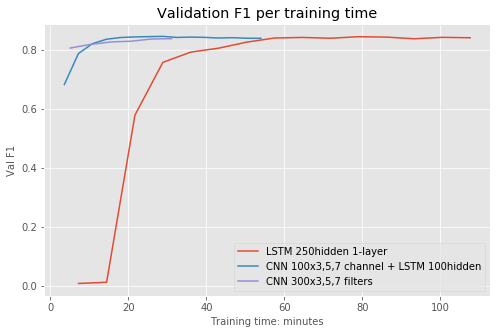

In [81]:
# SAME WITH DIFFERENT BACKGROUND

# grey background with lines
plt.style.use('ggplot')

#plt.switch_backend('agg')
# F1 Per training time
#epochs = len(train_losses)
res = results
plt.figure(figsize=(8,5))

for i in range(len(res)):
    
    #epochs = len(res['Train_f1'][i])
    #plt.plot(np.arange(1,epochs+1), res['Train_f1'][i], label=res['Model'][i] +' train f1')
    plt.plot(res['Time'][i]/60, res['Val_f1'][i], label=res['Desc'][i] +'')

plt.title('Validation F1 per training time')
plt.xlabel('Training time: minutes', fontsize=10)
plt.ylabel('Val F1', fontsize=10)
plt.legend()
plt.show()

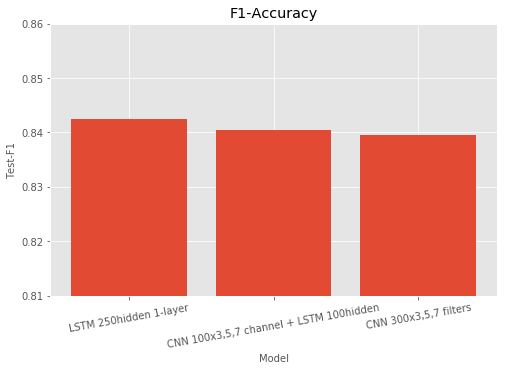

In [83]:
# Bar
index = np.arange(len(res))
values = res['Test_f1']
labels = res['Desc']

#plt.ylim = ([0.5, 0.9]) # is set, but not effecting bar
#plt.ylim(bottom= 0.5)
plt.figure(figsize=(16,10))
plt.figure(figsize=(8,5))
plt.gca().set_ylim(.81, .86)
plt.bar(index, values)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Test-F1', fontsize=10)
plt.xticks(index, labels, fontsize=10, rotation=10)
plt.title('F1-Accuracy')

plt.show()

### Rest is Extra - not included yet

### Train individual

In [64]:
# on small1-data
# LSTM v2, 400 epoch, val f1 0.529 1900 sec
# CNN "CNN 200x3,5,7 channel" , 44 epochs. 0.756, about 140 sec

sum(times)

458.6244578361511

In [33]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)

### Results

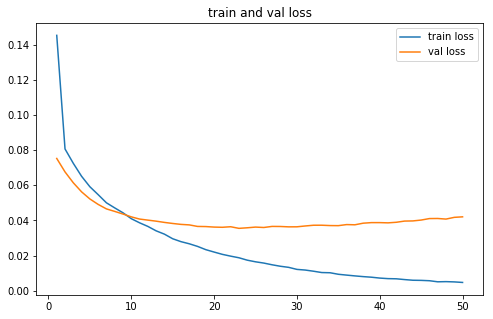

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = len(train_losses)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_losses, label='train loss')
plt.plot(np.arange(1,epochs+1), val_losses, label='val loss')
plt.title('train and val loss')
plt.legend()

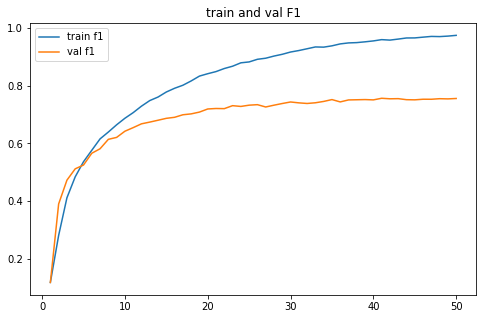

In [31]:
# Per ecpoh

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_f1s, label='train f1')
plt.plot(np.arange(1,epochs+1), val_f1s, label='val f1')
plt.title('train and val F1')
plt.legend()

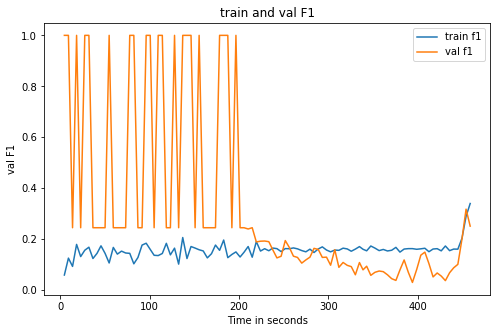

In [65]:
# Per time

times_cumul = pd.Series(times).cumsum() # cumulative time

plt.figure(figsize=(8,5))
plt.plot(times_cumul, train_f1s, label='train f1')
plt.plot(times_cumul, val_f1s, label='val f1')
plt.title('train and val F1')
plt.xlabel('Time in seconds', fontsize=10)
plt.ylabel('val F1', fontsize=10)
plt.legend()

In [ ]:
model2.load_state_dict(torch.load('model.pkl'))
                      

In [ ]:
model2.eval()

### Test it on test data

In [136]:
test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} ||Prec:{test_precision:.3f} |Rec:{test_recall:.3f} |Test F1:{test_f1: .3f} |')

| Test Loss: 0.060 ||Prec:0.707 |Rec:0.650 |Test F1: 0.677 |


### Use final scoring 

The results will be ranked according to the highest micro-averaged F1 score. This will be calculated using the f1_score function found in scikit-learn, using a command like f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document i contains the label j.

In [ ]:
from sklearn.metrics import f1_score
f1_score()